# Création d'un espace de quaternions pour le jeu de données

## Contexte

Dans le cadre de mon stage au sein du CEA, mon projet consiste à développer une architecture permettant d'obtenir un encodage pertinent de transformations (rotations et translations) de certaines formes géométriques (géons) dans un espace en trois dimensions. Afin d'effectuer cet encodage, deux modèles différents vont être implémentés : un VAE (Variational Auto Encoder) ainsi qu'un FRBM (Factorial Restricted Boltzmann Machine). Ces deux réseaux non supervisés possèdent de nombreuses différences, notamment sur le paradigme d'apprentissage : le VAE s'entraîne sur des images d'entrées à fournir un encodage pertinent à partir duquel il est capable de reconstruire les données à quelques variations près. Lors de l'apprentissage, une rétropropagation du gradient permet de minimiser une certaine fonction de perte. Le FRBM quant à lui est un modèle basé sur l'énergie : durant l'apprentissage son but est non pas de minimiser une fonction de perte, mais de maximiser une fonction d'énergie lorsque la probabilité d'obtenir un certain couple de données d'entrées est élevée. Dans le cadre de ce projet, nous souhaitons que notre FRBM soit capable d'encoder la transformation appliquée d'une première image vers une seconde image. Afin que cet encodage soit pertinent, il est donc nécessaire de lui fournir des couples d'images pour lesquelles les transformations effectuées recouvrent l'espace des transformations possibles. Dans le cas contraire, l'encodage obtenu n'est pas pertinent. 
C'est pourquoi, penser à la création de la base de données est une étape fondamentale dans ce projet. 
Ce document porte sur la création du jeu de données que nous utiliserons lors de l'apprentissage des différentes architectures implémentées. Dans un premier temps, nous discuterons de la première approche utilisée pour créer un ensemble d'images dont le contenu est soumis à un ensemble de rotations. Cette approche comporte certaines limitations qu'il nous a fallu éviter. C'est pourquoi nous parlerons également de la façon finale dont notre jeu de données a été créé, et grâce à laquelle nous pourrons visionner une partie du résultat. 

Ce présent Notebook est également associé à un script python ("creating_space.py") ainsi qu'un script Blender ("compute_rotations.blend") qui nous ont permis d'obtenir le résultat final. 

## Première approche : Rotations d'Euler

### Explications

Aux prémices du projet, il nous a paru naturel de créer l'ensemble des images de notre jeu de données en utilisant les angles d'Euler. Les angles d'Euler correspondent à trois angles permettant de décrire l'orientation d'un repère mobile Rm (0x'y'z') par rapport à un référentiel Rf (0xyz) considéré comme fixe. Ainsi, d'après cette définition (Léonard Euler, 1707-1783 ), n'importe quelle orientation de Rm peut être obtenue en composant trois rotations autour des axes du système de coordonnées de Rf, soit : 
- Une rotation d'angle $\varphi$ ou $\alpha$ d'axe Oz,
- Une rotation d'angle $\theta$ ou $\beta$ d'axe Ox,
- Une rotation d'angle $\psi$ ou $\gamma$ d'axe Oz


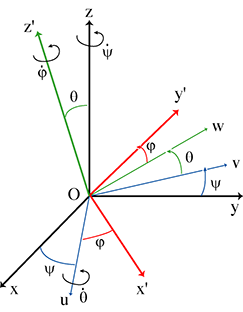

In [1]:
from IPython.display import Image
Image("img/AngleEuler.png")

_Angles d'Euler $\varphi$ , $\theta$  et $\psi$ . Le système fixe est indiqué en noir (Oxyz), le système mobile en rouge (Ox'y'z') et la ligne des nœuds en bleu (Ou)._  (voir https://fr.qwe.wiki/wiki/Euler_angles)

### Mise en pratique

Ainsi, pour construire notre jeu de données, nous avions à disposition une dizaine de fichiers STL, chacun représentant un géon. Nous avons alors utilisé le logiciel de modélisation 3D Blender, grâce auquel nous avons créée une scène, importé un mesh, et appliqué une rotation sur cet objet. Pour chaque rotation, un fichier au format png, de taille 128x128 était enregistré. 

Afin d'appliquer nos rotations, nous avons défini une séquence d'angles d'Euler à appliquer à notre forme. Pour cela, trente-six valeurs de $\alpha$ , $\beta$  et $\gamma$ comprises entre zéro et trois-cent-soixante degrés avec un pas de dix ont été définies. Enfin, nous avons calculées l'ensemble des combinaisons qu'il était possible d'effectuer et avons fais tourné notre objet avec ces séquences obtenues, tout en faisant attention à l'ordre des rotations appliquées autour des axes (ces angles pouvant se traduire par une matrice de rotation, ce sont donc des corps non commutatifs. Ainsi l'ordre auquel on les applique importe sur le résultat obtenu). 

Finalement, une fois l'ensemble de nos images créées, nous devions penser à la création du jeu d'entraînement spécifique au FRBM, consistant à un couple d'images aléatoires parmis notre jeu de données et la transformation appliquée à la première image afin d'obtenir la seconde.  

### Problème rencontré

Néanmoins, l'utilisation des angles d'Euler pour la création du jeu de données nous posée deux problèmes fondamentaux pour continuer la suite du projet. Effectivement, bien que les angles d'Euler proposent un moyen de décrire numériquement toute rotation dans un espace à trois dimensions en utilisant trois nombres, cette description n'est pas unique. Effectivement, il est possible d'appliquer deux séquences de transformations différentes et d'obtenir finalement la même disposition de l'objet dans l'espace. Bien que cela ne soit pas fondamentalement dérangeant pour la qualité de notre jeu de données, cela implique que le nombre d'images créées n'est pas minimal et alourdi considérablement la taille du fichier (constitué de 36*36*36 images pour chaque fichier STL). De plus, il existe certains points pours lesquels toutes les rotations ne peuvent pas être réalisées en changeant les angles d'Euler. Ce phénomène, appelé le Gimbal Lock ('blocage de cardan'), consiste à la perte d'un degrés de liberté lorsque deux des axes des trois gimbals (un 'gimbal' est un anneau suspendu pouvant tourner autour d'un axe),  se retrouvent dans une configuration parallèle : cela bloque le système en une rotation dans un espace à deux dimensions dégénéré.

Illustrons cela. Comme dit précédemment, il est possible de représenter des transformations d'Euler sous forme matricielle. En reprenant les représentations ci-dessus, avec $\alpha$ et $\gamma$ contraints dans l'intervalle [-$\pi$, $\pi$] et $\beta$ dans l'intervalle [$0$, $\pi$]  : 

$$R= \begin{bmatrix}
1 & 0 & 0\\
0 & cos \alpha & - sin \alpha \\  
0 & sin \alpha & cos \alpha 
\end{bmatrix}
\begin{bmatrix}
cos \beta & 0 & sin \beta\\ 
0 & 1 & 0 \\ 
-sin \beta & 0 & cos \beta
\end{bmatrix}
\begin{bmatrix}
cos \gamma & -sin \gamma & 0 \\ 
sin \gamma & cos \gamma & 0 \\ 
0 & 0 & 1 
\end{bmatrix}$$

Un exemple pertinent parvient lorsque $\beta$ = $\frac{\pi}{2}$. En sachant que cos($\frac{\pi}{2}$)=0 et sin($\frac{\pi}{2}$)=1, l'expression ci-dessus devient:

$$R= \begin{bmatrix}
1 & 0 & 0\\
0 & cos \alpha & - sin \alpha \\  
0 & sin \alpha & cos \alpha 
\end{bmatrix}
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & 0 \\ 
-1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
cos \gamma & -sin \gamma & 0 \\ 
sin \gamma & cos \gamma & 0 \\ 
0 & 0 & 1 
\end{bmatrix}$$

en multipliant les matrices:

$$R= \begin{bmatrix}
0 & 0 & 1 \\ 
sin \alpha & cos \alpha & 0 \\ 
-cos \alpha & sin \alpha & 0
\end{bmatrix}
\begin{bmatrix}
cos \gamma & -sin \gamma & 0 \\ 
sin \gamma & cos \gamma & 0 \\ 
0 & 0 & 1 
\end{bmatrix}
=
\begin{bmatrix}
0 & 0 & 1 \\ 
sin \alpha cos \gamma + cos \alpha sin \gamma & -sin \alpha sin \gamma + cos \alpha cos \gamma & 0 \\ 
-cos \alpha cos \gamma + sin \alpha sin \gamma & cos \alpha sin \gamma + sin \alpha cos \gamma & 0 
\end{bmatrix}
$$

Et finallement en utilisant les formules de trigonométrie:

$$R= \begin{bmatrix}
0 & 0 & 1 \\ 
sin(\alpha + \gamma) & cos(\alpha + \gamma) & 0 \\ 
-cos(\alpha + \gamma) & sin(\alpha + \gamma) & 0
\end{bmatrix} $$


Changer les valeurs de alpha et gamma dans la matrice ci-dessus à le même effet: l'angle de rotation $\alpha$ + $\gamma$ change mais l'axe de rotation reste dans la direction de z. Effectivement, la dernière colonne et la première ligne de la matrice ne changent pas. La seule solution pour que $\alpha$ et $\gamma$ retrouvent des rôles différents est de changer $\beta$.

Ainsi, nous nous sommes rendus compte que les images que nous avions dans un premier temps générées en traduisant les transformations par des angles d'Euler n'était pas pertinent car non unique mais également par la dégénéréscende de l'espace dans lequel les rotations étaient effectuées. 

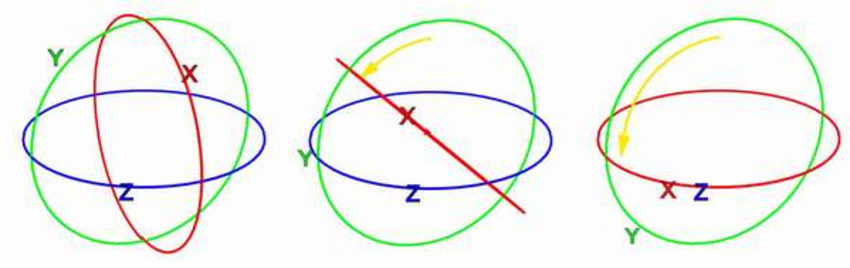

In [20]:
from IPython.display import Image
Image("img/gl.png")

_Lorsque le cercle rouge est aligné au cercle bleu, les mouvements de ces deux cercles coincident. C'est à ce moment qu'apparaît le "gimbal lock" : un degrés de liberté est perdu._ (voir https://www.researchgate.net/figure/Gimbal-lock-When-the-pitch-Y-rotates-90-degrees-the-roll-X-and-yaw-Z-axes-become_fig14_46720588 )


## Deuxième approche : Quaternions

De par ce problème rencontré, il nous a fallu trouver une solution permettant de paver notre espace de rotations de façon rigoureuse, afin d'avoir un jeu de données pertinent. Pour cela, la topologie des rotations devaient être incluses dans une hypersphère à quatre dimensions. C'est pourquoi nous avons pensé à appliquer les transformations de nos objets à partir de quaternions (Hamilton, 1843).

### Explications

Un quaternion est un quadruplet de nombres réels (a,b,c,d), mais vu comme le 'nombre' appartenant à l'ensemble H, 
q = a + bi + cj +dk avec $i^2$+$j^2$+$k^2$=ijk=-1.

L'ensemble des quaternions unitaires (dont la norme est 1) fournissent une notation mathématiques pertinentes pour représenter la rotation d'un objet dans un espace à trois dimensions. Leur utilisation permet ainsi de s'affranchir de la situation de gimbal lock, mais ils sont également plus simples à composer. 
Ainsi, le quaternion de coordonnées (w,x,y,z) peut être perçu comme une rotation d'angle w autour de l'axe [x,y,z]. 



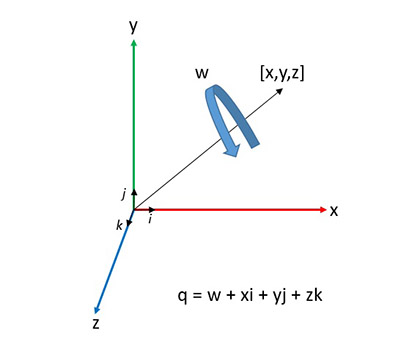

In [3]:
from IPython.display import Image
Image("img/quaternion_jpg.jpg")

_Quaternion q dangle W et d'axe de rotation [x,y,z]_

### Mise en pratique

La suite du document permet un aperçu de l'utilisation des quaternions pour faire tourner nos objets et ainsi obtenir un jeu de données pertinent. Afin de générer nos quaternions unitaires, nous avons appliquée la formule de Marsaglia (1972) afin que nos quaternions soient soient uniformément répartis sur une hypersphere. Ensuite il était nécessaire de trouver la transformation nous permettant de passer d'un quaternion à un deuxième quaternion. Finalement, il était nécessaire de paver notre espace dans sa globalité, mais également de façon continue. Ce sont ces trois points que nous allons discuter dans les sections suivantes. Le code associé aux graphiques est présent dans le script python joint "creating_space.py"

#### Aperçu  du recouvrement de l'espace

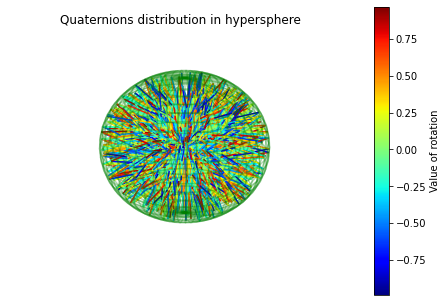

<Figure size 432x288 with 0 Axes>

In [6]:
import warnings
warnings.filterwarnings('ignore')

from creating_space import *
Space = Space(1000, 0)
space = Space.create_space_distribution()
Space.plot_hypersphere(space)

La figure 3D ci-dessus représente la distributions de 1000 quaternions répartis uniformément dans une hypersphere (d'après les formules de Marsaglia, 1972). Les vecteurs dans l'hypersphère représentent l'axe de rotation des différents quaternions, et la couleur la valeur de rotation (w) de chaque quaternion.

On remarque ainsi qu'avec 1000 quaternions, il est possible de représenter pertinemment l'espace des rotations. Cela est considérablement moins qu'avec l'utilisation des angles d'Euler, où l'on obtenait in finé 36x36x36 images, soit 46656 images. L'utilisation de quaternions nous permet ainsi de réduire la taille de notre jeu de données de manière pertinente. 

#### Vérification de la transformation

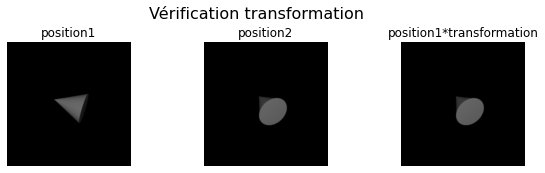

In [7]:
import matplotlib.image as mpimg
x = mpimg.imread('img/position1.png') 
y = mpimg.imread('img/position2.png') 
z = mpimg.imread('img/position1*transf.png') 
labels = ['position1', 'position2', 'position1*transformation']

images = [x,y,z]
fig = plt.figure(figsize=(10,5))
fig.suptitle("Vérification transformation", fontsize=16)
columns = 3

for i, image in enumerate(images):

    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.gca().set_title(labels[i])
    plt.imshow(image)
    plt.axis('off')

Les trois images ci-dessus ont été effectuées grâce au logiciel Blender. Parmis les 1000 quaternions générés, deux on été tirés aléatoirement (q1,q2). La première image représente notre objet STL tourné par le premier quaternion, puis la deuxième image notre objet tourné par le second quaternion. Finalement, pour obtenir la troisième image, nous avons calculé la transformation permettant d'aller de q1 à q2, et nous avons verifié que cette transformation équivalait bien à faire tourner notre objet par q2. On peut ainsi vérifier que la transformation obtenue est pertinente, car les deux dernières images sont tout à fait similaires. 

#### Continuité dans l'espace

Afin d'assurer une certaine continuité dans notre espace, il nous a fallu considérer que notre objet était dans une position initiale ( associée au quaternion d'angle nul, q=(1,0,0,0)), et trouver séquentiellement l'ensemble des meilleurs quaternions à venir. Un quaternion est considéré comme un "bon candidat" au quaternion précédent si la transformation qui lui est associée à partir du quaternion précédent est proche du quaternion d'angle nul, mais également si cette transformation est proche de la transformation effectuée précédemment. A partir de ces deux critères, une mesure de distance va être définie, et le quaternion suivant va être choisi aléatoirement parmi les n meilleurs. 
Ainsi, le paramètre "n" est un paramètre important à déterminer et peut modifier considérablement la continuité des quaternions dans la séquence déterminée. Les figures suivantes vont nous permettre de déterminer n. 

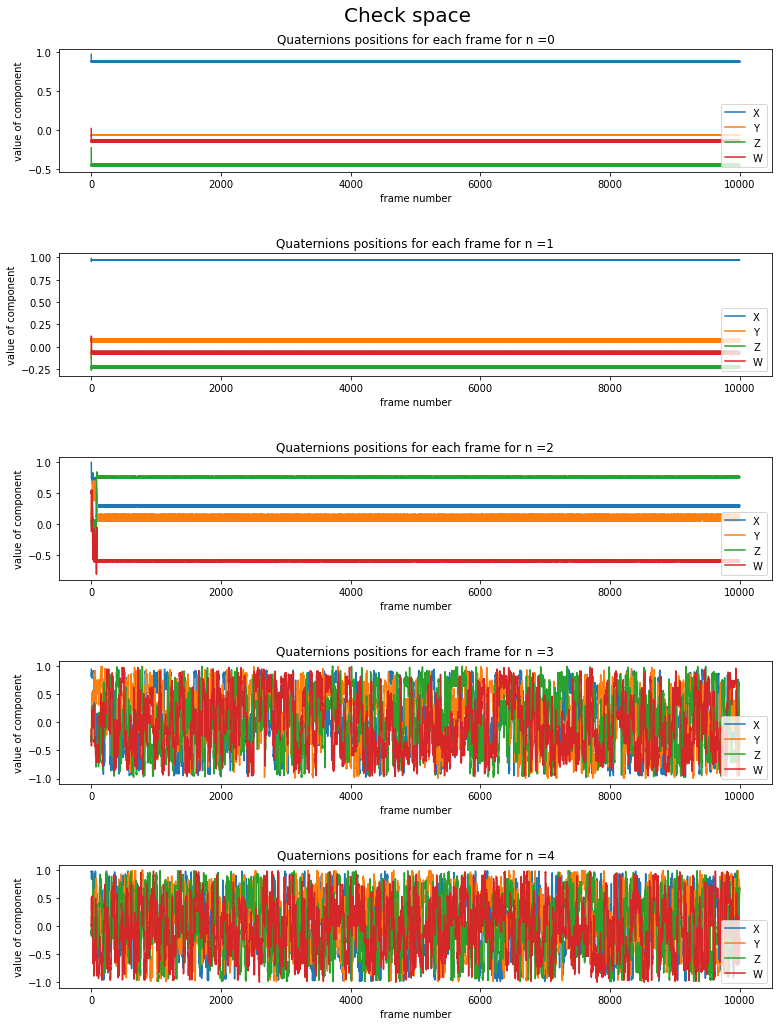

In [8]:
X, Y, Z ,W = [],[],[],[]
different_n = []
position_list_np_array = []
for n in range(5):
    from creating_space import *
    Space = Space(1000, n)
    space = Space.create_space_distribution()
    position_list, _, position_list_np = Space.explore_space(space)
    different_n.append(position_list)
    position_list_np_array.append(position_list_np)
    
fig, axes = plt.subplots(5, figsize=(12, 15))
fig.suptitle("Check space", fontweight='light', fontsize=20)
fig.tight_layout(pad=6.0)

for i, _ in enumerate(different_n):
    axes[i].set_title("Quaternions positions for each frame for n =" + str(i))
    axes[i].plot(position_list_np_array[i], label=['X','Y','Z','W'])
    axes[i].set_xlabel('frame number')
    axes[i].set_ylabel('value of component')
    axes[i].legend(["X","Y","Z","W"], loc='lower right')

éplt.show()

La figure ci-dessus représente l'ensemble des valeurs prises par chaque composantes w,x,y,z des quaternions lorsque l'on fait varier n de zéro à quatre. D'après ces figures, on peut en déduire que le choix de n (nombre de quaternions "les plus proches" d'après notre critère de similarité parmis lesquels on va piocher le quaternion suivant )est relativement important pour recouvrir pertinement l'ensemble de notre espace. On remarque que lorsque est compris entre 0 (c'est à dire que l'on considère uniquement le quaternion le plus proche ) et 2, alors l'espace des quaternions n'est pas recouvert dans sa totalité. Cela s'explique par le fait que le choix de quaternions reste "bloqué" dans un endroit restreint de l'espace. Néanmoins, lorsque n est égal à 3 ou 4, alors les valeurs prises pour x,y, z et w semblent bien couvrir l'intervalle [-1, 1].  

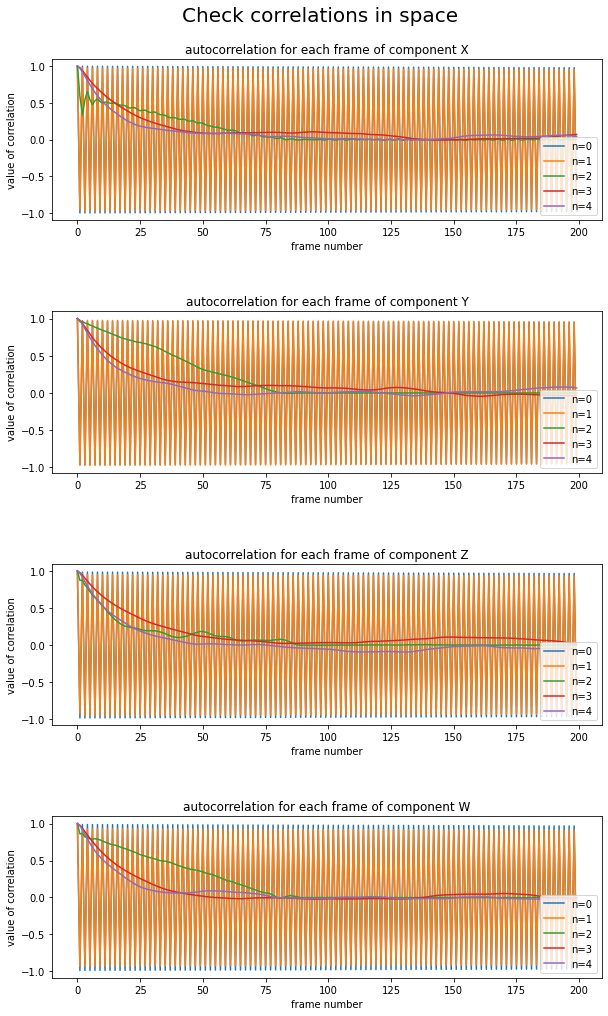

In [9]:
# https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
def autocorr5(x,lags):
    '''numpy.correlate, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]


X, Y, Z ,W = [],[],[],[]
for i, _ in enumerate(different_n):
    x_tab, y_tab, z_tab ,w_tab = [],[],[],[]
    for j in range(len(different_n[i])):
        x_tab.append(different_n[i][j].x)
        y_tab.append(different_n[i][j].y)
        z_tab.append(different_n[i][j].z)
        w_tab.append(different_n[i][j].w)
    X.append(x_tab)
    Y.append(y_tab)
    Z.append(z_tab)
    W.append(w_tab)
        

correlations_x = []
for x in X:
    correlation = autocorr5(np.asarray(x), range(200))
    correlations_x.append(correlation)

correlations_y = []
for y in Y:
    correlation = autocorr5(np.asarray(y), range(200))
    correlations_y.append(correlation)
    
correlations_z = []
for z in Z:
    correlation = autocorr5(np.asarray(z), range(200))
    correlations_z.append(correlation)
    
correlations_w = []
for w in W:
    correlation = autocorr5(np.asarray(w), range(200))
    correlations_w.append(correlation)
    
correlations_plot=[correlations_x, correlations_y,correlations_z,correlations_w]
labels = ['X', 'Y', 'Z', 'W']

fig, axs = plt.subplots(4, figsize=(10,15))
fig.suptitle("Check correlations in space", fontweight='light', fontsize=20)
fig.tight_layout(pad=7.0)

for i, _ in enumerate(correlations_plot):
    for j, _ in enumerate(correlations_plot[i]):
        axs[i].set_title("autocorrelation for each frame of component "+labels[i])
        axs[i].plot(correlations_plot[i][j])
        axs[i].set_xlabel('frame number')
        axs[i].set_ylabel('value of correlation')
        axs[i].legend(["n=0","n=1","n=2","n=3", "n=4"], loc='lower right')



Finalement, afin de déterminer avec quelle valeur de n nous parcourions mieux l'espace, nous avons analysée la figure ci-dessus. Cette dernière représente une mesure de progression de chaque composante w,x,y,z par rapport au frame : l'autocorrelation de chaque composante avec elle même. Cette mesure nous permet de quantifier la vitesse d'exposition des quaternions.
En examinant les graphiques, on remarque pour les valeurs de n à 0 et à 1, l'autocorrelation n'est pas pertinente. Cela confirme ce que nous avons remarqué lors de notre analyse de recouvrement de l'espace, ci-dessus. Lorsque n=2, la valeur de l'autocorrelation décroît relativement plus rapidement que lorsque n=4. Ainsi, elle nous intéresse moins. Pour les composantes x, y et w on peut observer que pour n=3 cette autocorrelation semble être plus élevée, plus longtemps, mais également plus pertinente que pour les autres valeurs de n. Utiliser cette valeur pour créer notre espace nous assure qu'il ne soit pas tout à fait déterministe, mais que néanmoins l'ensemble de l'espace soit recouvert et qu'il y ait également une certaine contuinuité dans les quaternions créés. C'est donc pour nous la valeur la plus pertinente.  

### Résultats obtenus avec  n = 3

In [10]:
from creating_space import *
Space = Space(1000, 3)
space = Space.create_space_distribution()
position_list, _, position_list_np = Space.explore_space(space)

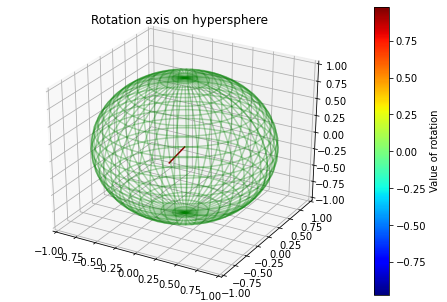

In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

nfr = len(position_list) # Number of frames
fps = 10 # Frame per sec

ss = np.arange(1,nfr,0.5)

X, Y, Z ,W = np.array([]),np.array([]),np.array([]),np.array([])

for i, _ in enumerate(position_list):
    X = np.append(X, position_list[i].x)
    Y = np.append(Y, position_list[i].y)
    Z = np.append(Z, position_list[i].z)
    W = np.append(W, position_list[i].w)
        
colorsMap='jet'
cm = plt.get_cmap(colorsMap)
cNorm = colors.Normalize(vmin=min(W), vmax=max(W))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
scalarMap.set_array(W)

fig = plt.figure()
ax = Axes3D(fig)

sct, = ax.plot([],[],[], color=[])

def update(ifrm, xa, ya, za, w):
    sct.set_data([0, xa[ifrm]], [0,ya[ifrm]])
    sct.set_3d_properties([0,za[ifrm]])
    sct.set_color(scalarMap.to_rgba(w[ifrm]))
    return sct,

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

u = np.linspace( 0, 2 * np.pi, 50 )
v = np.linspace( 0, np.pi, 25 )
x = 1 * np.outer( np.cos( u ), np.sin( v ) )
y = 1 * np.outer( np.sin( u ), np.sin( v ) )
z = 1 * np.outer( np.ones( np.size( u ) ), np.cos( v ) )
ax.plot_wireframe( x, y, z, color='g', alpha=.3 )

fig.colorbar(scalarMap,label='Value of rotation')
plt.axis('on')
plt.title('Rotation axis on hypersphere')
animation.FuncAnimation(fig, update, nfr, fargs=(X,Y,Z,W), interval=1000/fps, blit=True)

In [ ]:
ani.save('rotation_axis.gif', writer='imagemagick')

L'animation ci-dessus représente l'ensemble des quaternions créés dans l'espace, en fonction de chaque frame. Le vecteur représente l'axe de rotation du quaternion, et la couleur correspond à la valeur de rotation de ce quaternion. 
Pour n=1 on remarque qu'il y a une certaine contuinité dans l'espace ainsi que dans la valeur des rotations. Effectivement, on ne remarque pas de changements brutaux de direction de vecteur ou encore de changement de couleur brusque passant directement du rouge au bleu. Cela confirme notre choix d'utiliser n=1.

## Conclusion

In [ ]:
filepath ='/Users/jouffroy/Downloads/Emma/espace/dataset/'
filename = 'rotating_object'
Space.create_gif(filepath, filename)

In [ ]:
from IPython.display import Image
Image("img/rotating_object_min.gif")

Grâce au logiciel Blender, et au script python "creating_space.py", nous avons créé le GIF ci-dessus, représentant un STL composé d'un cône tourner. Chacune des rotation est effectuée à partir d'un quaternion dans l'espace créé. On peut ainsi remarquer que le cône semble prendre toutes les directions possibles sans pour autant qu'il n'y ait de discontuinuité importante dans les rotations.
On peut donc en conclure que l'espace de rotations créé est pertinent pour notre jeu de données. 